### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display
from torch.utils.data import Subset
from torchvision.datasets import CocoDetection
from PIL import Image as PILImage
import numpy as np
import imageio
import tempfile
import os
from tqdm import tqdm
from IPython.display import Markdown

#### Prepare Dataset

In [2]:
dataset_path = 'data/custom_dataset'
annotations_path = 'annotations.json'

coco_dataset = CocoDetection(root=dataset_path,
                             annFile=annotations_path,
                             transform=None)

total_images = len(coco_dataset)
print(f'Number of images: {total_images}')

loading annotations into memory...
Done (t=9.92s)
creating index...
index created!
Number of images: 36150


#### View Data

In [3]:
def plot_image(img, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
category_mapping = {
    1: "living_cell",
    2: "dead_cell",
}

def plot_annotation(target, title):
    print(f"{title} Annotations:")
    for annotation in target:
        category_id = annotation.get('category_id', 'N/A')
        # track_id = annotation.get('track_id', 'N/A')
        track_id = annotation.get('label', 'N/A')
        bbox = annotation.get('bbox', 'N/A')  # Bounding box: [x, y, width, height]
        centroid = annotation.get('centroid', 'N/A')
        area = annotation.get('area', 'N/A')
        time_step = annotation.get('time_step', 'N/A')
        death_time = annotation.get('death_time', 'N/A')
        iscrowd = annotation.get('iscrowd', 'N/A')

        category_name = category_mapping.get(category_id, "Unknown Category")

        print(f"Annotation ID: {annotation['id']}")
        print(f"  - Track ID: {track_id}")
        print(f"  - Category ID: {category_id} ({category_name})")
        print(f"  - Centroid: {centroid}")
        print(f"  - Bounding Box: {bbox} (x, y, width, height)")
        print(f"  - Area: {area}")
        print(f"  - Time Step: {time_step}")
        print(f"  - Death Time: {death_time}")
        print(f"  - Is Crowd: {iscrowd}")
        print("-" * 50)

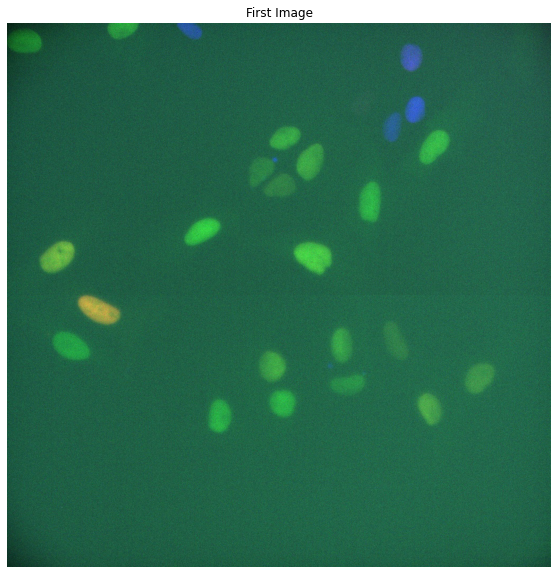

In [5]:
first_img, first_target = coco_dataset[0]
plot_image(first_img, 'First Image')

In [6]:
plot_annotation(first_target, 'First Image')

First Image Annotations:
Annotation ID: 1
  - Track ID: 1
  - Category ID: 1 (living_cell)
  - Centroid: [0.0517578125, 0.0361328125]
  - Bounding Box: [0.03271484375, 0.03369140625, 0.0615234375, 0.0400390625] (x, y, width, height)
  - Area: 0.0024633407592773438
  - Time Step: 0
  - Death Time: None
  - Is Crowd: 0
--------------------------------------------------
Annotation ID: 2
  - Track ID: 2
  - Category ID: 1 (living_cell)
  - Centroid: [0.220703125, 0.0009765625]
  - Bounding Box: [0.21240234375, 0.0146484375, 0.0556640625, 0.029296875] (x, y, width, height)
  - Area: 0.0016307830810546875
  - Time Step: 0
  - Death Time: None
  - Is Crowd: 0
--------------------------------------------------
Annotation ID: 3
  - Track ID: 4
  - Category ID: 1 (living_cell)
  - Centroid: [0.330078125, 0.0078125]
  - Bounding Box: [0.33544921875, 0.0146484375, 0.0458984375, 0.029296875] (x, y, width, height)
  - Area: 0.0013446807861328125
  - Time Step: 0
  - Death Time: None
  - Is Crowd: 0


In [7]:
def get_annotations(ax, img, target):
    annotations = []
    for annotation in target:
        # Extract bounding box coordinates
        x, y, w, h = annotation.get('bbox', [0, 0, 0, 0])
        # Convert normalized coordinates to absolute coordinates
        x *= img.shape[0]
        y *= img.shape[1]
        w *= img.shape[0]
        h *= img.shape[1]

        # Adjust x, y to draw the box from the top-left corner
        x_center, y_center = x, y
        x = x_center - w / 2
        y = y_center - h / 2

        # ID
        label_height = max(20, h * 0.1)
        fontsize = max(5, h * 0.075)

        # BBOX
        cell_rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none', linestyle='--')

        # Label
        label_rect = patches.Rectangle((x, y - label_height), w, label_height, linewidth=1, edgecolor='b', facecolor='none', linestyle='--')
        label_text = ax.text(x + w / 2, y - label_height / 2, f"ID: {annotation['label']}", color='blue', fontsize=fontsize, horizontalalignment='center', verticalalignment='center')

        ax.add_patch(cell_rect)
        ax.add_patch(label_rect)
        ax.add_artist(label_text)

        annotations.append((cell_rect, label_rect, label_text))
    return annotations

def plot_image_with_annotations(img, target, title, show_plot=True):
    if isinstance(img, PILImage.Image):
        img = np.array(img, dtype=np.uint8)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    get_annotations(ax, img, target)

    if show_plot:
        plt.show()

    return fig, ax

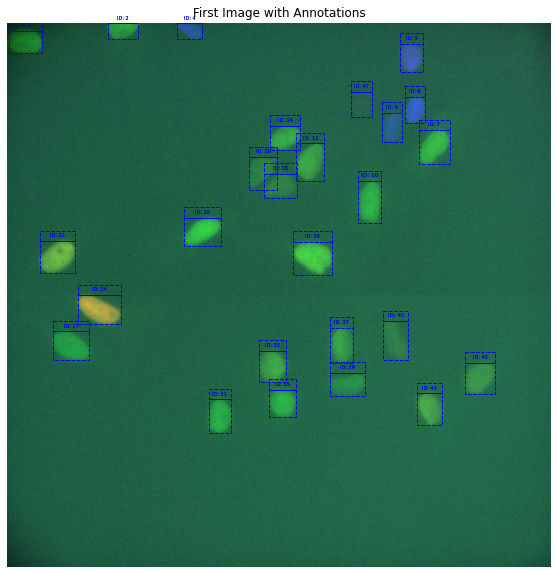

In [8]:
fig, ax = plot_image_with_annotations(first_img, first_target, 'First Image with Annotations')

In [9]:
def create_gif(dataset, filename, title,detections_dict=None):
    # Create a temporary directory to save frames
    temp_dir = tempfile.mkdtemp()

    # Generate frames and save as image files
    frame_files = []
    for i, (img, target) in tqdm(enumerate(dataset), desc='Processing images'):
        if detections_dict and (i in detections_dict):
            detections = detections_dict[i]
            fig, ax = plot_image_with_annotations_and_detections(
                img,
                target,
                detections,
                f"{title}\nFrame {i+1}",
                show_plot=False
            )
        else:
            fig, ax = plot_image_with_annotations(
                img,
                target,
                f"{title}\nFrame {i+1}",
                show_plot=False
            )

        frame_path = os.path.join(temp_dir, f"frame_{i:03d}.png")
        fig.savefig(frame_path, bbox_inches='tight')
        frame_files.append(frame_path)
        plt.close(fig)

    # Load all frames and save as a GIF
    frames = [imageio.imread(frame_file) for frame_file in frame_files]
    imageio.mimsave(filename, frames, fps=3)

    # Clean up temporary files
    for frame_file in frame_files:
        os.remove(frame_file)
    os.rmdir(temp_dir)
    print(f"GIF saved as {filename}")

In [10]:
indices = list(range(150))
subset_dataset = Subset(coco_dataset, indices)
create_gif(subset_dataset, filename='first_sequenz_with_annotations.gif', title='First Sequence')

Processing images: 150it [01:22,  1.83it/s]


GIF saved as first_sequenz_with_annotations.gif


In [11]:
gif_path = 'first_sequenz_with_annotations.gif'
display(Markdown(f"![Animated sequence]({gif_path})"))

![Animated sequence](first_sequenz_with_annotations.gif)

In [12]:
def load_detections(file_path):
    detections = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) > 1:
                frame_id = int(parts[0])
                detection_data = [int(parts[1])] + [float(x) for x in parts[2:6]] + parts[6:]
                if frame_id not in detections:
                    detections[frame_id] = []
                detections[frame_id].append(detection_data)
    return detections


def get_detections(dets, ax):
    detections = []
    for det in dets:
        label, x, y, w, h, *_ = det
        label_height = max(20, h * 0.1)
        fontsize = max(5, h * 0.075)

        cell_rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', linestyle='--')
        label_rect = patches.Rectangle((x, y - label_height), w, label_height, linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
        label_text = ax.text(x + w / 2, y - label_height / 2, f"ID: {label}", color='yellow', fontsize=fontsize, horizontalalignment='center', verticalalignment='center')

        ax.add_patch(cell_rect)
        ax.add_patch(label_rect)
        ax.add_artist(label_text)

        detections.append((cell_rect, label_rect, label_text))
    return detections


def plot_image_with_detections(img, detections, title):
    if isinstance(img, PILImage.Image):
        img = np.array(img, dtype=np.uint8)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    ax = plt.gca()

    get_detections(detections, ax)

    plt.axis('off')
    plt.show()

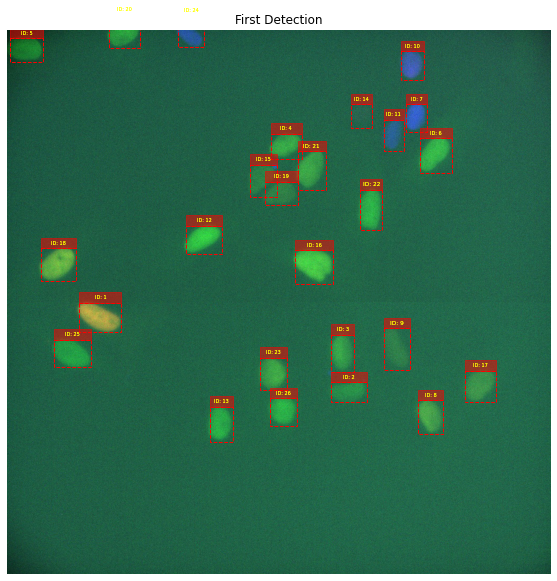

In [13]:
detections_file_path = 'det_sequence_001.txt'
detections = load_detections(detections_file_path)

frame_id = 1
frame_detections = detections.get(frame_id, [])

plot_image_with_detections(first_img, frame_detections, 'First Detection')

In [14]:
def plot_image_with_annotations_and_detections(img, target, detections, title, show_plot=True):
    img_array = np.array(img, dtype=np.uint8)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img)
    ax.set_title(title)
    ax.set_facecolor('white')

    # Display annotations in blue
    get_annotations(ax, img_array, target)

    # Display predictions in red
    get_detections(detections, ax)

    # Legend
    handles = [
        patches.Patch(color='blue', label='Original Annotation'),
        patches.Patch(color='red', label='Prediction (Trackformer)')
    ]
    ax.legend(handles=handles, loc='lower left')

    plt.axis('off')
    if show_plot:
        plt.show()

    return fig, ax

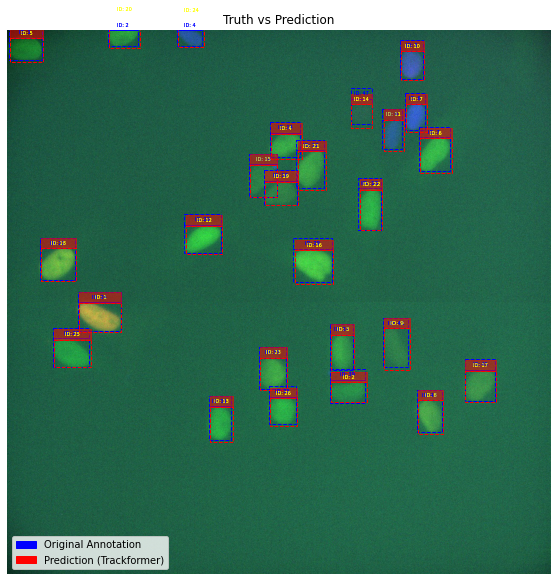

In [15]:
fig, ax = plot_image_with_annotations_and_detections(first_img, first_target, frame_detections, 'Truth vs Prediction')

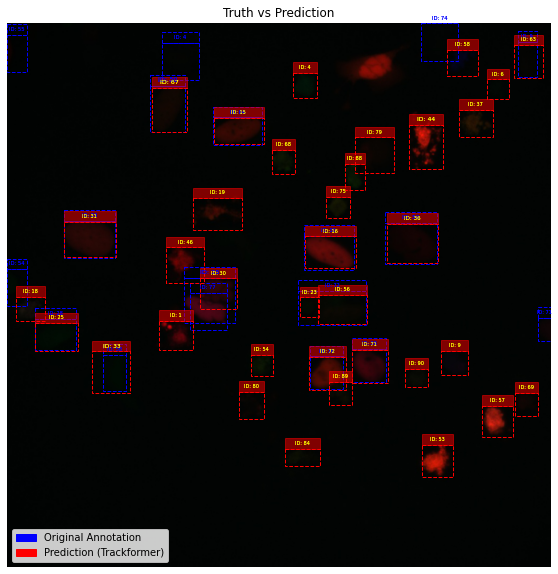

In [24]:
detections_file_path = 'det_sequence_001.txt'
detections = load_detections(detections_file_path)

frame_id = 150
frame_detections = detections.get(frame_id, [])

last_img, last_target = coco_dataset[149]

fig, ax = plot_image_with_annotations_and_detections(last_img, last_target, frame_detections, 'Truth vs Prediction')

In [17]:
indices = list(range(150))
subset_dataset = Subset(coco_dataset, indices)
detections_file_path = 'det_sequence_001.txt'
detections = load_detections(detections_file_path)

In [18]:
create_gif(subset_dataset, filename='final_sequence_with_annotations_and_detections.gif', title='First Sequence\nTruth vs Prediction', detections_dict=detections)

Processing images: 150it [02:21,  1.06it/s]


GIF saved as final_sequence_with_annotations_and_detections.gif


In [19]:
gif_path = 'final_sequence_with_annotations_and_detections.gif'
display(Markdown(f"![Animated sequence]({gif_path})"))

![Animated sequence](final_sequence_with_annotations_and_detections.gif)

### Results from the finetuned TrackFormer

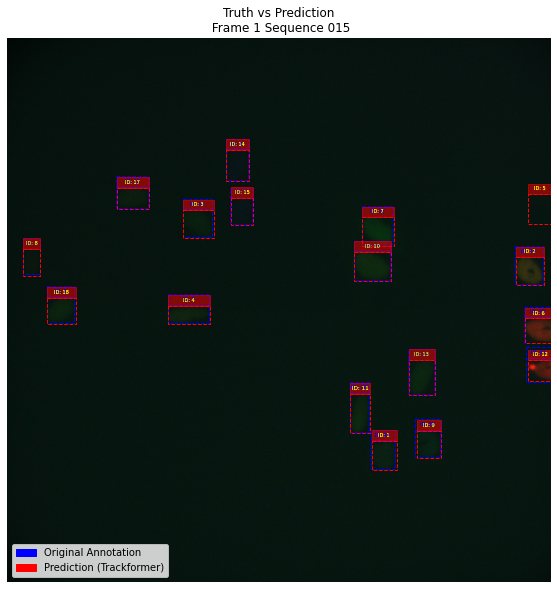

In [20]:
# Plot the First Image of the Testsequence 015
first_img_seq_015, first_target_img_seq_015 = coco_dataset[2100]

detections_file_path = 'custom_dataset'
detections = load_detections(detections_file_path)

frame_id = 1
frame_detections_seq_015 = detections.get(frame_id, [])

fig, ax = plot_image_with_annotations_and_detections(
    first_img_seq_015,
    first_target_img_seq_015,
    frame_detections_seq_015,
    f'Truth vs Prediction\n Frame {frame_id} Sequence 015'
)

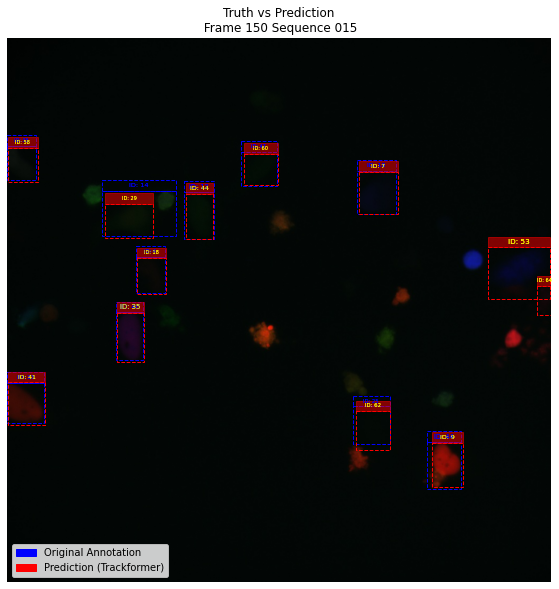

In [21]:
# Plot the Last Image of the Testsequence 015
last_img_seq_015, last_target_img_seq_015 = coco_dataset[2249]

detections_file_path = 'custom_dataset'
detections = load_detections(detections_file_path)

frame_id = 150
frame_detections_seq_015 = detections.get(frame_id, [])

fig, ax = plot_image_with_annotations_and_detections(
    last_img_seq_015,
    last_target_img_seq_015,
    frame_detections_seq_015,
    f'Truth vs Prediction\n Frame {frame_id} Sequence 015'
)

In [22]:
indices = list(range(2100, 2250))
subset_dataset = Subset(coco_dataset, indices)
detections_file_path = 'custom_dataset'
detections = load_detections(detections_file_path)

create_gif(subset_dataset, filename='test_sequence_with_annotations_and_detections.gif', title='Test Sequence 015\nTruth vs Prediction', detections_dict=detections)

Processing images: 150it [01:45,  1.43it/s]


GIF saved as test_sequence_with_annotations_and_detections.gif


In [26]:
gif_path = 'test_sequence_with_annotations_and_detections.gif'
display(Markdown(f"![Animated sequence]({gif_path})"))

![Animated sequence](test_sequence_with_annotations_and_detections.gif)